# RNA velocity in PFC

RNA velocity analysis with the *EM* and *steady-state models* using data preprocessed with `kallisto_bustools_prepref_isoseparate_exclude`.

**Requires**

* `adata_generation.ipynb`
* `velocyto_var_names.csv` from `velocyto_vi.ipynb`

**Output**

* `PROJECT_DIR/preprocessing_comparison/pfc/velocities/kallisto_isoseparate_exclude_steady_state.pickle`
* `PROJECT_DIR/preprocessing_comparison/pfc/velocities/kallisto_isoseparate_exclude_em.pickle`

## Library imports

In [1]:
import sys

import pandas as pd

import scanpy as sc
import scvelo as scv

sys.path.insert(0, "../../../")
from paths import DATA_DIR

In [2]:
sc.logging.print_version_and_date()

Running Scanpy 1.9.1, on 2022-07-14 11:33.


## General settings

In [3]:
# set verbosity levels
sc.settings.verbosity = 2
scv.settings.verbosity = 3

In [4]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

## Constants

In [5]:
N_JOBS = 8

In [6]:
VELOCYTO_VAR_NAMES = pd.read_csv('velocyto_var_names.csv', index_col=0, header=None).index.tolist()

## Data loading

In [7]:
adata = sc.read(
    DATA_DIR / 'pfc' / "kallisto_bustools_prepref_isoseparate_exclude.h5ad"
)
adata

AnnData object with n_obs × n_vars = 1267 × 54144
    obs: 'cell_index', 'clusters_coarse', 'clusters', 'X', 'nGene', 'nUMI', 'percent.mito', 'Sample', 'treatment', 'Period', 'stage', 'DevStage'
    layers: 'spliced', 'unspliced'

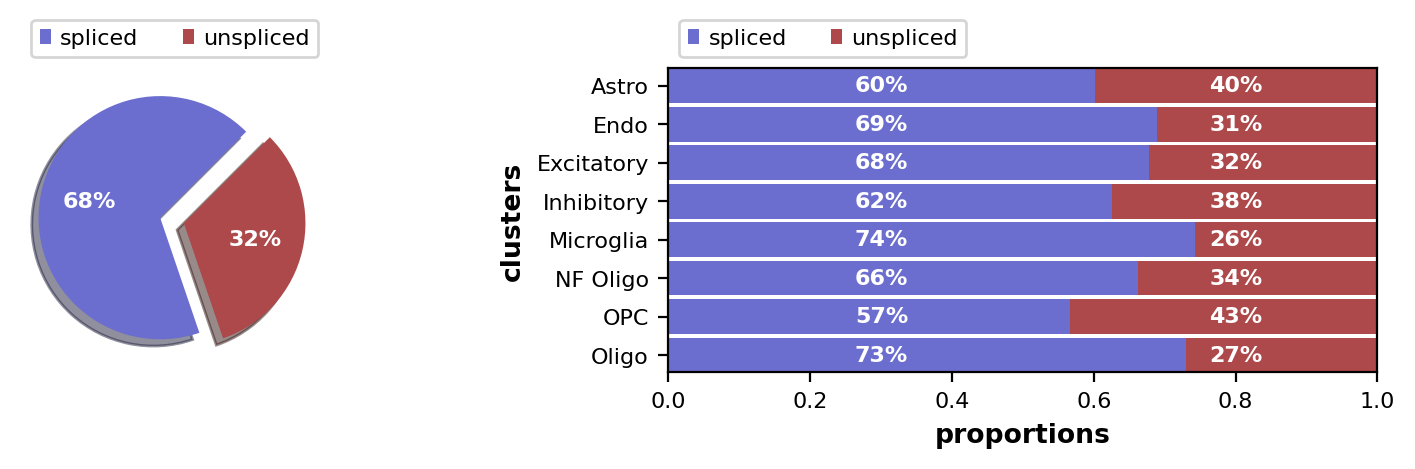

In [8]:
scv.pl.proportions(adata)

## Data pre-processing

In [9]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, retain_genes=VELOCYTO_VAR_NAMES)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 47515 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2165 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Model fitting

### Steady state

In [10]:
scv.tl.velocity(adata, mode="steady_state")
adata = adata[:, VELOCYTO_VAR_NAMES].copy()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [11]:
pd.DataFrame(
    adata.layers['velocity'],
    index=adata.obs_names,
    columns=adata.var_names
).to_pickle(
    DATA_DIR / 'pfc' / 'velocities' / 'kallisto_isoseparate_exclude_steady_state.pickle'
)

### EM

In [12]:
scv.tl.recover_dynamics(adata, var_names='all', n_jobs=N_JOBS)
scv.tl.velocity(adata, mode='dynamical')

recovering dynamics (using 8/64 cores)


  0%|          | 0/1336 [00:00<?, ?gene/s]

    finished (0:00:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [13]:
pd.DataFrame(
    adata[:, ~adata.var['fit_alpha'].isnull()].layers['velocity'],
    index=adata.obs_names,
    columns=adata.var_names[~adata.var['fit_alpha'].isnull()]
).to_pickle(
    DATA_DIR / 'pfc' / 'velocities' / 'kallisto_isoseparate_exclude_em.pickle'
)